In [ ]:
import gensim
import keras
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences


import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.preprocessing import LabelEncoder



np.random.seed(1003)

Using TensorFlow backend.


In [ ]:
W2V_DIR = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
DATA_DIR = ''
Glove = 'glove.6B.200d.txt'

# These are some hyperparameters that can be tuned
MAX_SENT_LEN = 170
MAX_VOCAB_SIZE = 400000
LSTM_DIM = 128
EMBEDDING_DIM = 300
BATCH_SIZE = 200
N_EPOCHS = 10

In [ ]:
train_bodies = pd.read_csv(DATA_DIR+'train_bodies.csv')
train_stances = pd.read_csv(DATA_DIR+'train_stances.csv')

test_bodies = pd.read_csv(DATA_DIR+'test_bodies.csv')
test_stances_unlabeled = pd.read_csv(DATA_DIR+'test_stances_unlabeled.csv')

In [ ]:
train = train_stances.join(train_bodies.set_index('Body ID'), on='Body ID')
test = test_stances_unlabeled.join(test_bodies.set_index('Body ID'), on='Body ID')

In [ ]:
train.replace('unrelated',1,True)
train.replace('agree',2,True)
train.replace('disagree',3,True)
train.replace('discuss',4,True)

In [ ]:
word_seq_headline_train = [text_to_word_sequence(sent) for sent in train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(sent) for sent in train['articleBody']]

word_seq_headline_test = [text_to_word_sequence(sent) for sent in test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(sent) for sent in test['articleBody']]

In [ ]:
word_seq = []
for i in range(len(word_seq_headline_train)):
  word_seq.append(word_seq_headline_train[i])
  
for i in range(len(word_seq_bodies_train)):
  word_seq.append(word_seq_bodies_train[i])

for i in range(len(word_seq_headline_test)):
  word_seq.append(word_seq_headline_test[i])

for i in range(len(word_seq_bodies_test)):
  word_seq.append(word_seq_bodies_test[i])

In [ ]:
for i in range (len(word_seq_headline_train)):
  word_seq_headline_train[i].extend(word_seq_bodies_train[i])

  
for i in range (len(word_seq_headline_test)):
  word_seq_headline_test[i].extend(word_seq_bodies_test[i])

In [ ]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])

In [ ]:
# Convert the sequence of words to sequnce of indices
X_train = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_train])
X_train = pad_sequences(X_train, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_train = train['Stance']
y_train = y_train.values


In [ ]:
from keras.utils import np_utils

encoder_train = LabelEncoder()
encoder_train.fit(y_train)
encoded_train = encoder_train.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, dummy_y_train, random_state=10, test_size=0.1)


In [ ]:
embeddings = gensim.models.KeyedVectors.load_word2vec_format(W2V_DIR, binary=True)

embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

In [ ]:

# Build a sequential model by stacking neural net units 
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer' 
                          ))
model.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer'))
model.add(Dropout(rate=0.5, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.8
model.add(Dense(4, activation='softmax', name='output_layer'))
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 300)         6714300   
_________________________________________________________________
lstm_layer (LSTM)            (None, 128)               219648    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 516       
Total params: 6,934,464
Trainable params: 220,164
Non-trainable params: 6,714,300
_________________________________________________________________
None


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

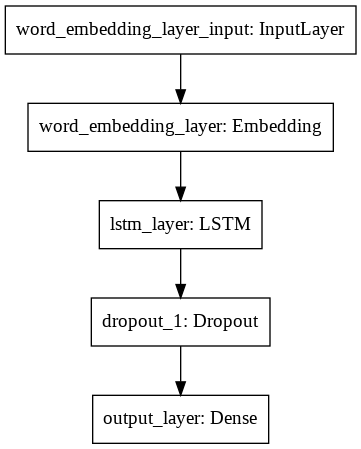

In [ ]:
keras.utils.plot_model(model, show_shapes=False)


In [17]:
history = model.fit(X_train, y_train,
          batch_size=100,
          epochs=20,
          validation_data=(X_val, y_val))

Train on 44974 samples, validate on 4998 samples
Epoch 1/20
44974/44974 [==============================] - 385s 9ms/step - loss: 0.7932 - accuracy: 0.7298 - val_loss: 0.7529 - val_accuracy: 0.7293
Epoch 2/20
44974/44974 [==============================] - 395s 9ms/step - loss: 0.7352 - accuracy: 0.7378 - val_loss: 0.7080 - val_accuracy: 0.7393
Epoch 3/20
44974/44974 [==============================] - 378s 8ms/step - loss: 0.6899 - accuracy: 0.7516 - val_loss: 0.6757 - val_accuracy: 0.7569
Epoch 4/20
44974/44974 [==============================] - 360s 8ms/step - loss: 0.6438 - accuracy: 0.7674 - val_loss: 0.6434 - val_accuracy: 0.7739
Epoch 5/20
44974/44974 [==============================] - 360s 8ms/step - loss: 0.6116 - accuracy: 0.7795 - val_loss: 0.6212 - val_accuracy: 0.7731
Epoch 6/20
44974/44974 [==============================] - 371s 8ms/step - loss: 0.5876 - accuracy: 0.7863 - val_loss: 0.6167 - val_accuracy: 0.7693
Epoch 7/20
44974/44974 [==============================] - 368s 

In [18]:
with open('LSTM_W2V', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

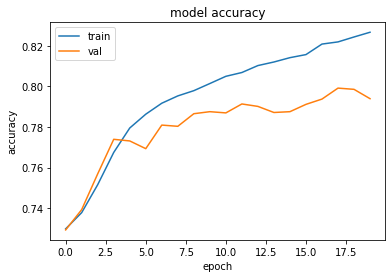

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
from keras.models import load_model

model.save('LSTM_W2V.h5')

In [21]:
competetion_bodies = pd.read_csv(DATA_DIR+'competition_test_bodies.csv')
competetion_stances = pd.read_csv(DATA_DIR+'competition_test_stances.csv')

competetion_unlabeled = pd.read_csv(DATA_DIR+'competition_test_stances_unlabeled.csv')

comp = competetion_stances.join(competetion_bodies.set_index('Body ID'), on='Body ID')

In [22]:
comp.replace('unrelated',1,True)
comp.replace('agree',2,True)
comp.replace('disagree',3,True)
comp.replace('discuss',4,True)

In [23]:
word_seq_headline_comp = [text_to_word_sequence(sent) for sent in comp['Headline']]
word_seq_bodies_comp = [text_to_word_sequence(sent) for sent in comp['articleBody']]

In [24]:
for i in range (len(word_seq_headline_comp)):
  word_seq_headline_comp[i].extend(word_seq_bodies_comp[i])

In [25]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_comp])

In [26]:
X_comp = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_comp])
X_comp = pad_sequences(X_comp, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_comp = comp['Stance']
y_comp = y_comp.values

In [27]:
encoder_comp = LabelEncoder()
encoder_comp.fit(y_comp)
encoded_comp = encoder_comp.transform(y_comp)
dummy_y_comp = np_utils.to_categorical(encoded_comp)

In [28]:
y_Uni = model.predict(X_comp)
score,acc = model.evaluate(X_comp, dummy_y_comp)


25413/25413 [==============================] - 89s 3ms/step


In [29]:
from score import report_score
outputs = [np.argmax(p) for p in y_Uni]

for i in range(len(outputs)):
    if outputs[i] == 0: outputs[i] = "unrelated"
    if outputs[i] == 1: outputs[i] = "disagree"
    if outputs[i] == 2: outputs[i] = "agree"
    if outputs[i] == 3: outputs[i] = "discuss"
#print (np.unique(outputs))

cs = pd.read_csv(DATA_DIR+'competition_test_stances.csv')
stance_true = cs['Stance'].values
from score import report_score
print ("Weighted Score")
report_score(stance_true, outputs)

Predicted = {}
Predicted = pd.DataFrame({'Stance': outputs})
result = pd.concat([competetion_unlabeled, Predicted], axis=1, sort=False)
result.to_csv('submission_LSTM_W2V.csv', index=False, encoding='utf-8')

Weighted Score
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     4     |    113    |    464    |   1322    |
-------------------------------------------------------------
| disagree  |     1     |    37     |    145    |    514    |
-------------------------------------------------------------
|  discuss  |     6     |    204    |    978    |   3276    |
-------------------------------------------------------------
| unrelated |    30     |    882    |   4522    |   12915   |
-------------------------------------------------------------
Score: 4481.0 out of 11651.25	(38.4593927690162%)


In [30]:
np.save('my_history.npy',history.history)

In [31]:
history=np.load('my_history.npy',allow_pickle='TRUE').item()

In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

accuracy = accuracy_score(stance_true, outputs)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(stance_true, outputs, average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(stance_true, outputs,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(stance_true, outputs, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.548302
Precision: 0.553530
Recall: 0.548302
F1 score: 0.546558
